In [1]:
import random
import statistics
import pandas as pd
import vaex
import json
import numpy as np
import seaborn as sns
import unittest

from leximpact_prepare_data.scenario_tools.calib_and_copules import (
    get_borders,
    get_fake_data,
    anonimyze_value,
    Quantile,
    SecretViolation,
    get_primary_buckets,
    DatasetNotSorted,
    get_calib,
    bucket_merge_with_above,
    pandas_to_vaex,
    DistribDeVarVaex,
    get_copulas,
    copulas_to_array,
    SECRET_KEEPED,
    anonimyze_lower_and_upper_bound,
    enforce_secret,
    get_copules_revkire,
    reduce_bucket_number,
)

tc = unittest.TestCase()

# Extraction de la fonction de répartition d'une variable en fonction d'une autre : création de copules

Objectif: Obtenir une indication sur la répartition d'une variable secondaire (salaire par exemple) par rapport à une variable primaire (le RFR : revenu fiscal de référence) sur toute la population française.

Ceci afin de pouvoir corriger l'échantillon des données fournit par l'INSEE dans l'Enquête Revenus ERFS-FPR.

Dans la documentation nous utilisons le terme RFR pour parler de la première variable utiliser pour le découpage, mais cela peut-être n'importe quelle variable.

Méthode :
- Découper les revenus en tranches ou _bucket_ séparées par des frontières de revenu
- A l'intérieur de chaque tranche de RFR, nous découpons la variable secondaire en tranche selon le principe suivant :
    - La découpe se fait en 100 tranches égales, en terme de personnes, auxquelles on ajoute des tranches plus fines sur les hauts revenus.
    - Cependant le découpage est limité par le respect du secret statistique :
        - Pas moins de 12 personnes par tranche
        - Un foyer de la tranche ne doit pas représenter plus que 85% de la valeur total des montants de la tranche.

En sortie on obtien la structure de données suivante :
```python
 'copules': [{'lower_bound': 0, # Frontière basse de RFR
   'upper_bound': 15, # Frontière haute de RFR
    'count': 3185458, # Nombre de foyer dans cette tranche de RFR, le zero/non zero concerne la variable secondaire
    'count_zero': 3160962,
    'count_nonzero': 24496,
   'buckets': [
            {
              "lower_bound": 0,
              "upper_bound": 0.5,
              "bucket_count": 3160962,
              "bucket_sum": 0,
              "bucket_mean": 0,
              "bucket_stdev": 0,
              "count_above_upper_bound": 24496,
              "sum_above_upper_bound": 30295559.0,
              "ratio_count_above_upper_bound": 0.007689945998346235,
              "mean_above_upper_bound": 1236.7553478118878
            },
            {
              "lower_bound": 0.5,
              "upper_bound": 2.0,
              "bucket_count": 244,
              "bucket_sum": 311.0,
              "bucket_mean": 1.2745901639344261,
              "bucket_stdev": 0.4472249092000875,
              "count_above_upper_bound": 24252,
              "sum_above_upper_bound": 30295248.0,
              "ratio_count_above_upper_bound": 0.007613347907898959,
              "mean_above_upper_bound": 1249.1855517070758
            }}, # Liste des tranches secondaires, avec pour valeurs [nombre de foyer, somme de la variable secondaire]
...
  {'lower_bound': 500000,
   'upper_bound': 1000000000000000,
   'count': 17,
   'count_zero': 0,
   'count_nonzero': 17,
   'buckets': [{
              "lower_bound": 57924.5,
              "upper_bound": 1000000,
              "bucket_count": 142,
              "bucket_sum": 18427874.0,
              "bucket_mean": 129773.76056338029,
              "bucket_stdev": 159227.9047663527,
              "count_above_upper_bound": 0,
              "sum_above_upper_bound": 0,
              "ratio_count_above_upper_bound": 0,
              "mean_above_upper_bound": 0
            }]}]}
```

## `get_borders` Méthode de découpage de frontière dynamique

Ajoute des frontières pour les hauts revenus et vérifie le respect du nombre de personne à l'intérieur de chaque frontière.

La découpe se fait en 100 tranches égales, en terme de personnes, auxquelles on ajoute des tranches plus fines sur les hauts revenus.

Cependant le découpage est limité par le respect du secret statistique :
    - Pas moins de 12 personnes par tranche

La vérification qu'un foyer de la tranche ne représente pas plus que 85% de la valeur total des montants de la tranche est fait dans une autre fonction. Ici on découpe sans s'occuper du contenu, seulement du nombre d'éléments.

Pour comprendre le besoin de mieux détailler les hauts revenus, voici les foyers qui existaient en 2019 dans les trés hauts revenus fiscaux de références :
- Entre 10 millions et 100 millions : 294 soit 7 personnes sur 1_000_000
- Entre 1 million et 10 millions : 10 061 soit 2 personnes sur 10_000
- Entre 500 000 € et 1 million : 22 745 soit 6 personnes sur 10_000
- Entre 250 000 et 500 000 : 88 849 soit 2 personnes sur 1_000
- Entre 150 000 et 250 000 : 236 470 soit 6 personnes sur 1_000


## `get_primary_buckets` - Méthode de calcul des tranches de RFR

Objectif : Déterminer les tranches de RFR.

On appel la méthode de découpe en tranche, puis on retire celles où le revenu le plus élevé est zéro.

## `get_copulas` : Méthode de préparation des tranches de variables à analyser

Objectif : Pour chaque tranche de RFR :
- Extraire les valeurs de la variable secondaire.
- Retirer les valeurs à 0.
- Les triers par ordre croissant.
- Appeler la méthode de calcul des copules DistribDeVar.

## `DistribDeVarVaex` Méthode de calcul des copules

Objectif :
- Découper en tranche la variable secondaire, dans une tranche de RFR donné.
- Vérifier le respect du secret statistique.
- Sauvegarder le nombre de foyer et la somme de la variable pour chaque tranche.

# `get_fake_data` Fabrication d'un faux jeux de données

Ce faux jeux de données va nous permettre de tester notre solution sur un problème simplifié.

On va considérer que le RFR croit linéairement dans une population de 10 000 foyers.
Et une variable va évoluer en fonction du RFR. Tout en pouvant être à zéro.

Nous pourrons ainsi constater facilement si notre distribution générée correspond à celle initiale.

/home/cgl/leximpact/leximpact-prepare-data/.venv/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cgl/leximpact/leximpact-prepare-data/.venv/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cgl/leximpact/leximpact-prepare-data/.venv/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/cgl/leximpact/leximpact-prepare-data/.venv/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype

<Axes: >

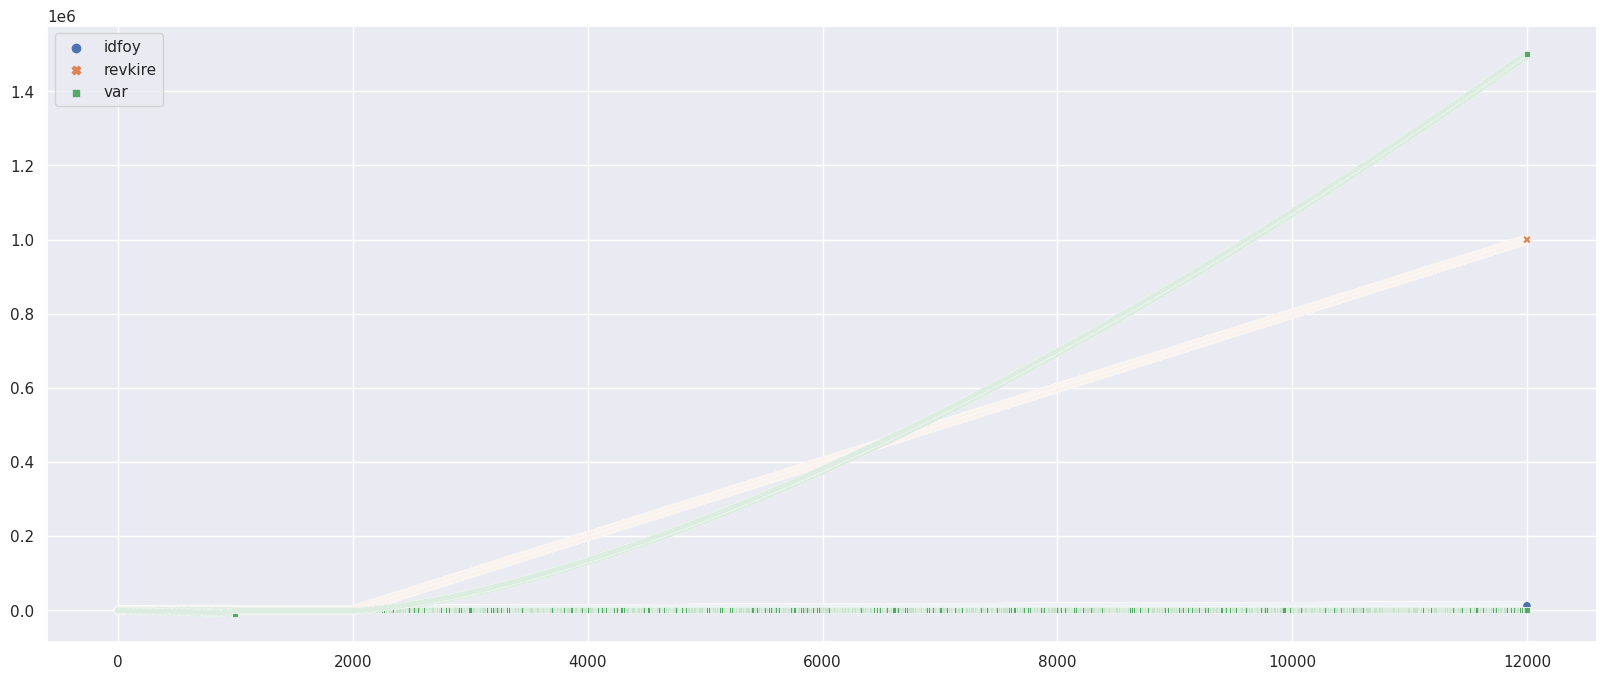

In [2]:
sns.set(rc={"figure.figsize": (20, 8)})
df = get_fake_data(set_some_var_to_zero=True)
sns.scatterplot(data=df)

In [3]:
rfrs_sorted = pandas_to_vaex(df)

# Génération de calibration

Les calibrations sont des copules avec une seule tranche de RFR.


## Keep bound secret

In [4]:
tc.assertEqual(anonimyze_value(1e15), 1e15)
tc.assertEqual(anonimyze_value(9), 10)
tc.assertEqual(anonimyze_value(9, min_len=1), 9)
tc.assertEqual(anonimyze_value(15), 100)
tc.assertEqual(anonimyze_value(499), 1000)
tc.assertEqual(anonimyze_value(100_000), 100_000)
tc.assertEqual(anonimyze_value(100_001), 1e6)
tc.assertEqual(anonimyze_value(999_999), 1e6)
tc.assertEqual(anonimyze_value(207736.8799), 1e6)
# tc.assertEqual(anonimyze_value("toto"), 1e6)
tc.assertEqual(anonimyze_value(-125.55, min_len=2), -1000)
tc.assertEqual(anonimyze_value(-125.55, min_len=3), -125.55)
tc.assertEqual(anonimyze_value(-2_025.30), -10_000)

# TESTS

In [5]:
minimal_bucket_size = 12

## Tests découpage de frontières

In [6]:
# | export


def get_ecart_frontiere(frontieres, minimal_bucket_size=12):
    prec = 0
    ecart = []
    for f in frontieres:
        e = f - prec
        if e < minimal_bucket_size:
            return False
        ecart.append(e)
        prec = f
    return ecart

#### Pas assez d'éléments

In [7]:
nb_elements_a_decouper = minimal_bucket_size - 1
nb_bucket = 3
frontieres = get_borders(nb_elements_a_decouper, nb_bucket, debug=True)
assert frontieres == []

WARNING get_borders, moins de 12 éléments => On retourne une liste vide. !!!!!!!!!!


#### Juste assez d'éléments

In [8]:
nb_elements_a_decouper = minimal_bucket_size
nb_bucket = 100
frontieres = get_borders(nb_elements_a_decouper, nb_bucket, debug=True)
assert frontieres == [12]

#### Pas assez d'éléments pour en faire deux

In [9]:
nb_elements_a_decouper = minimal_bucket_size + 1
nb_bucket = 100
frontieres = get_borders(nb_elements_a_decouper, nb_bucket, debug=True)
assert frontieres == [13]

#### Juste assez d'éléments pour en faire deux

In [10]:
nb_elements_a_decouper = minimal_bucket_size * 2
nb_bucket = 100
frontieres = get_borders(nb_elements_a_decouper, nb_bucket, debug=True)
assert frontieres == [12, 24]

get_borders frontieres de base [12]
get_borders frontieres avant [12, 22, 24]
get_borders len(borders) avant 3
get_borders On supprime la frontière i+1 1 pour combiner les 2 buckets mitoyens : borders[i]=12, borders[i+1]=22 , borders[i+2]=24
get_borders frontieres apres [12, 24]
get_borders frontieres avant fin [12, 24]


#### Pas assez d'éléments pour en faire trois

In [11]:
nb_elements_a_decouper = 3 * minimal_bucket_size - 1
nb_bucket = 100
frontieres = get_borders(nb_elements_a_decouper, nb_bucket, debug=True)
assert frontieres == [17, 35]

get_borders frontieres de base [17]
get_borders frontieres avant [17, 32, 35]
get_borders len(borders) avant 3
get_borders On supprime la frontière i 1 pour combiner les 2 buckets mitoyens : borders[i]=32, borders[i+1]=35 
get_borders frontieres apres [17, 35]
get_borders frontieres avant fin [17, 35]


#### Juste assez d'éléments pour en faire trois

In [12]:
nb_elements_a_decouper = 3 * minimal_bucket_size
nb_bucket = 100
frontieres = get_borders(nb_elements_a_decouper, nb_bucket, debug=True)
assert frontieres == [12, 24, 36]

get_borders frontieres de base [12, 24]
get_borders frontieres avant [12, 24, 33, 36]
get_borders len(borders) avant 4
get_borders On supprime la frontière i+1 2 pour combiner les 2 buckets mitoyens : borders[i]=24, borders[i+1]=33 , borders[i+2]=36
get_borders frontieres apres [12, 24, 36]
get_borders frontieres avant fin [12, 24, 36]


#### Assez d'éléments pour en faire trois

In [13]:
nb_elements_a_decouper = 3 * minimal_bucket_size + 1
nb_bucket = 100
frontieres = get_borders(nb_elements_a_decouper, nb_bucket, debug=True)
assert frontieres == [12, 24, 37]

get_borders frontieres de base [12, 24]
get_borders frontieres avant [12, 24, 34, 37]
get_borders len(borders) avant 4
get_borders On supprime la frontière i+1 2 pour combiner les 2 buckets mitoyens : borders[i]=24, borders[i+1]=34 , borders[i+2]=37
get_borders frontieres apres [12, 24, 37]
get_borders frontieres avant fin [12, 24, 37]


#### Pas assez d'éléments pour en faire 100

In [14]:
nb_elements_a_decouper = 100
nb_bucket = 100
frontieres = get_borders(nb_elements_a_decouper, nb_bucket, debug=True)
assert frontieres == [12, 25, 37, 50, 62, 75, 87, 100]

get_borders frontieres de base [12, 25, 37, 50, 62, 75, 87]
get_borders frontieres avant [12, 25, 37, 50, 62, 75, 87, 90, 99, 100]
get_borders len(borders) avant 10
get_borders On supprime la frontière i+1 7 pour combiner les 2 buckets mitoyens : borders[i]=87, borders[i+1]=90 , borders[i+2]=99
get_borders On supprime la frontière i 7 pour combiner les 2 buckets mitoyens : borders[i]=99, borders[i+1]=100 
get_borders frontieres apres [12, 25, 37, 50, 62, 75, 87, 100]
get_borders frontieres avant fin [12, 25, 37, 50, 62, 75, 87, 100]


#### Juste assez d'éléments pour en faire 100

In [15]:
nb_bucket = 100
nb_elements_a_decouper = minimal_bucket_size * nb_bucket

frontieres = get_borders(nb_elements_a_decouper, nb_bucket, debug=False)
assert len(frontieres) == 100
assert get_ecart_frontiere(frontieres) is not False

#### Assez d'éléments pour ajouter la tranche de 10%

In [16]:
nb_bucket = 10
nb_elements_a_decouper = (minimal_bucket_size * 10) * nb_bucket
frontieres = get_borders(nb_elements_a_decouper, nb_bucket, debug=False)
assert len(frontieres) == nb_bucket + 1
assert get_ecart_frontiere(frontieres) is not False

#### Assez d'éléments pour ajouter la tranche de 1%

In [17]:
nb_bucket = 10
nb_elements_a_decouper = (minimal_bucket_size * 100) * nb_bucket
frontieres = get_borders(
    nb_elements_a_decouper,
    nb_bucket,
    add_upper_bucket=[0.1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    debug=False,
)
tc.assertEqual(len(frontieres), nb_bucket + 2)
assert get_ecart_frontiere(frontieres) is not False

#### Assez d'éléments pour ajouter la tranche de 0.000001 (1 pour 1 million)

In [18]:
nb_bucket = 10
nb_elements_a_decouper = (minimal_bucket_size * 1_000_00) * nb_bucket
frontieres = get_borders(
    nb_elements_a_decouper,
    nb_bucket,
    add_upper_bucket=[0.1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    debug=False,
)
assert len(frontieres) == nb_bucket + 5
assert get_ecart_frontiere(frontieres) is not False

In [19]:
print(get_ecart_frontiere(frontieres)[-1])
print(nb_elements_a_decouper)
get_ecart_frontiere(frontieres)[-1] / nb_elements_a_decouper

12
12000000


1e-06

In [19]:
print(f"{1e-6:2f}")

0.000001


## Tests of Quantile
### Nominal test

In [20]:
nb_bucket = 10
nb_elements_a_decouper = minimal_bucket_size * nb_bucket
frontieres = get_borders(nb_elements_a_decouper, nb_bucket, debug=False)
tc.assertEqual(len(frontieres), nb_bucket)
assert get_ecart_frontiere(frontieres) is not False
data = []
for i, f in enumerate(frontieres):
    data += [i for v in range(minimal_bucket_size)]
tc.assertEqual(data[nb_elements_a_decouper - 1], nb_bucket - 1)

In [21]:
q = Quantile(data, minimal_bucket_size=minimal_bucket_size, debug=True)
decile = q.get_quantile(nb_bucket)
for b in decile["buckets"]:
    tc.assertEqual(b["quantile_index"], b["bucket_mean"])
    tc.assertEqual(b["bucket_count"], minimal_bucket_size)

Quantile on borders 10


<Axes: xlabel='lower_bound'>

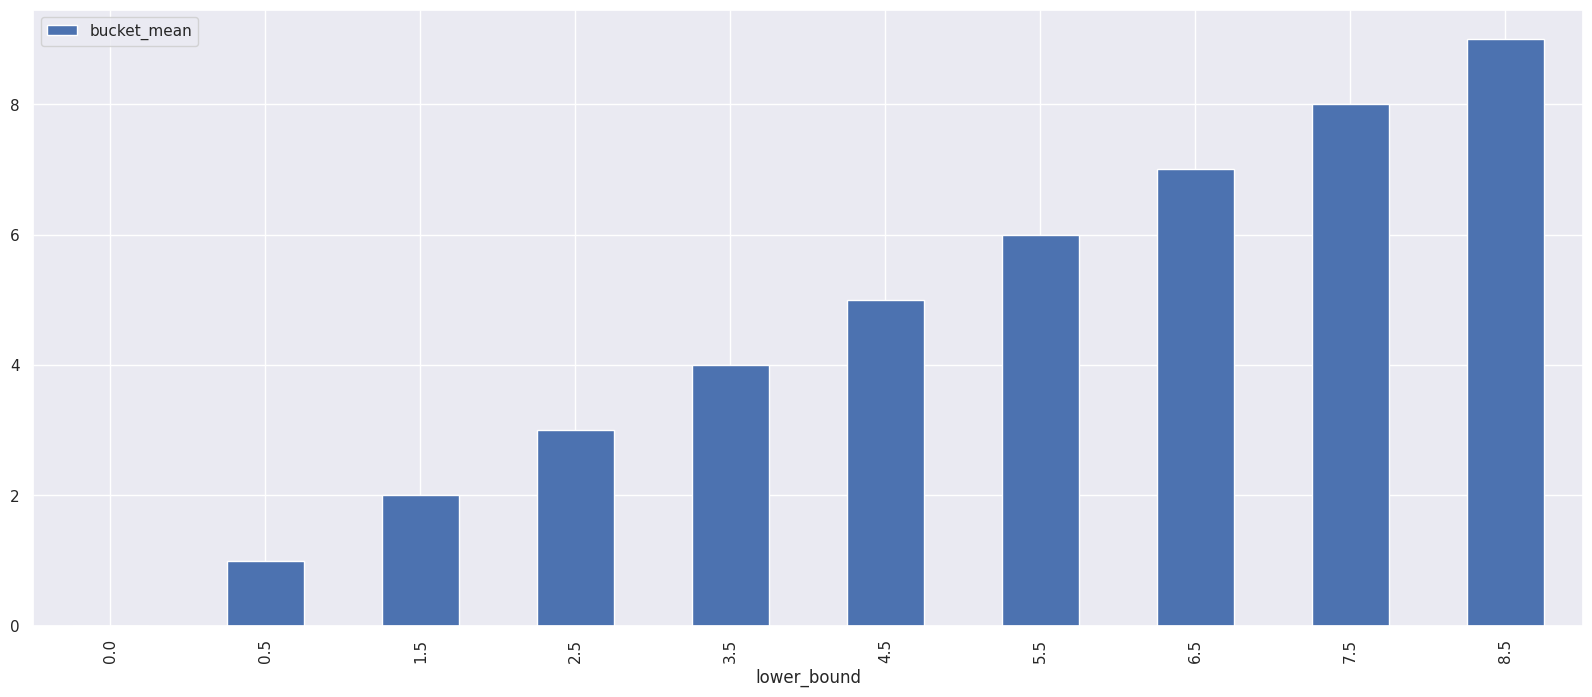

In [22]:
df = pd.DataFrame(decile["buckets"])
df.plot.bar(x="lower_bound", y="bucket_mean")

### Only zeros

In [23]:
nb_bucket = 10
nb_elements_a_decouper = minimal_bucket_size * nb_bucket
data = [0 for v in range(nb_elements_a_decouper)]
q = Quantile(data, minimal_bucket_size=minimal_bucket_size, debug=True)
decile = q.get_quantile(nb_bucket)

Quantile on borders 10


In [24]:
for b in decile["buckets"]:
    tc.assertEqual(b["bucket_count"], minimal_bucket_size)
    tc.assertEqual(b["bucket_mean"], 0)

### Different size

In [25]:
nb_bucket = 10
nb_elt_per_bucket = 100
nb_elements_a_decouper = nb_elt_per_bucket * nb_bucket
data = [1 for i in range(nb_elements_a_decouper)]
q = Quantile(data, minimal_bucket_size=minimal_bucket_size, debug=True)
decile = q.get_quantile(nb_bucket)
for b in decile["buckets"]:
    tc.assertEqual(1, b["bucket_mean"])
    tc.assertEqual(b["bucket_count"], nb_elt_per_bucket)
    tc.assertEqual(b["bucket_sum"], nb_elt_per_bucket)

Quantile on borders 10


<Axes: xlabel='lower_bound'>

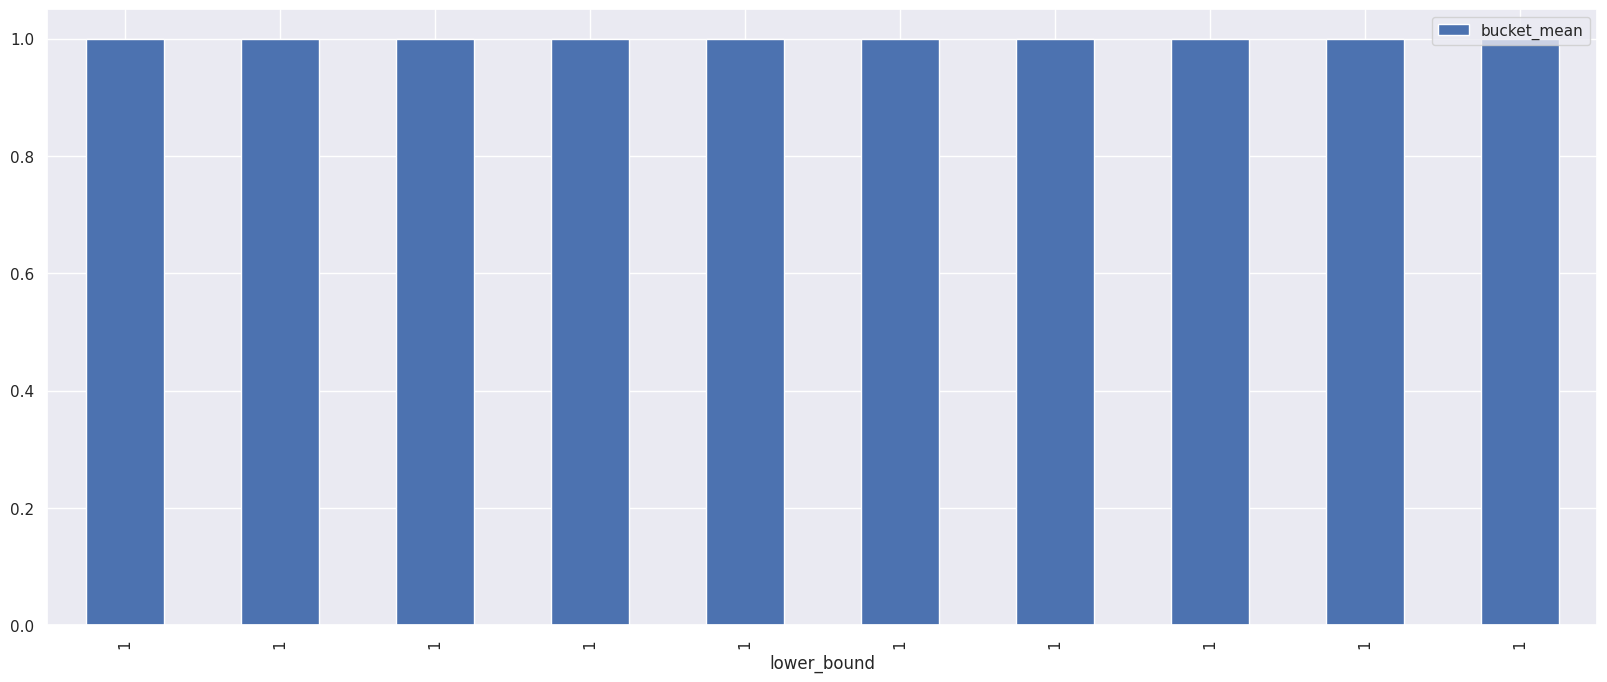

In [26]:
df = pd.DataFrame(decile["buckets"])
df.plot.bar(x="lower_bound", y="bucket_mean")

Quantile on borders 20


<Axes: xlabel='lower_bound'>

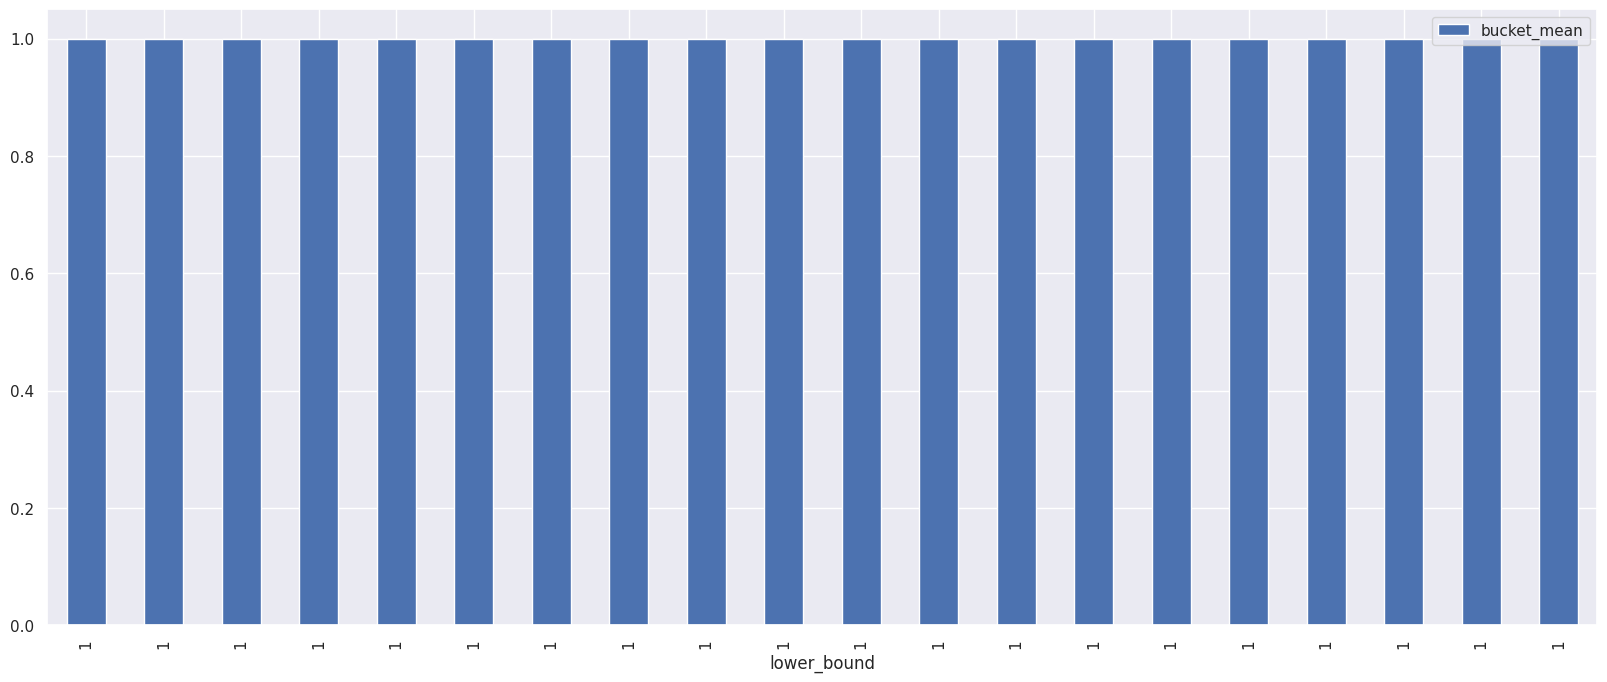

In [27]:
nb_bucket = 20
decile = q.get_quantile(nb_bucket)
for b in decile["buckets"]:
    tc.assertEqual(1, b["bucket_mean"])
    tc.assertEqual(b["bucket_count"], nb_elements_a_decouper / nb_bucket)
    tc.assertEqual(b["bucket_sum"], nb_elements_a_decouper / nb_bucket)
df = pd.DataFrame(decile["buckets"])
df.plot.bar(x="lower_bound", y="bucket_mean")

### More than 85%

In [28]:
autres = 100 * 1
riche = autres * 5.851
somme = autres + riche
print(
    "Riche",
    riche,
    "Somme des autres",
    autres,
    "Ratio:",
    riche / autres,
    "Ratio:",
    riche / somme,
)

Riche 585.1 Somme des autres 100 Ratio: 5.851 Ratio: 0.854035907166837


In [29]:
data = [1 for i in range(nb_elements_a_decouper)]
data[-1] = ((nb_elements_a_decouper / nb_bucket) - 1) * 0.849
q = Quantile(data, minimal_bucket_size=minimal_bucket_size)
quantile = q.get_quantile(nb_bucket)

data = [1 for i in range(nb_elements_a_decouper)]
data[-1] = ((nb_elements_a_decouper / nb_bucket) - 1) * 0.851
q = Quantile(data, minimal_bucket_size=minimal_bucket_size)
with tc.assertRaises(SecretViolation):
    quantile = q.get_quantile(nb_bucket)
# quantile["buckets"][-1]

### Not enough data

In [30]:
nb_bucket = 10
nb_elt_per_bucket = 10
nb_elements_a_decouper = nb_elt_per_bucket * nb_bucket
data = [1 for i in range(nb_elements_a_decouper)]
q = Quantile(data, minimal_bucket_size=minimal_bucket_size, debug=True)

with tc.assertRaises(SecretViolation):
    q.get_quantile(nb_bucket)

## Test calcul des tranches de RFR

### Test de tri du dataset

In [31]:
test_dict = {"revkire": [0, 1, 2, 3]}
vdf_test = vaex.from_dict(test_dict)
tranche_rfr_small_test = get_primary_buckets(vdf_test, 1)
tranche_rfr_small_test

WARNING get_borders, moins de 12 éléments => On retourne une liste vide. !!!!!!!!!!


{'borders_values': [0, 1000000000000000], 'borders': [4]}

In [32]:
test_dict = {"revkire": [0, 0, 0, 0]}
vdf_test = vaex.from_dict(test_dict)
tranche_rfr_small_test = get_primary_buckets(vdf_test, 1)

WARNING get_borders, moins de 12 éléments => On retourne une liste vide. !!!!!!!!!!


In [33]:
test_dict = {"revkire": [0, 1, 0, 0]}
vdf_test = vaex.from_dict(test_dict)
with tc.assertRaises(DatasetNotSorted):
    get_primary_buckets(vdf_test, 1, debug=True)

### Tests des tranches retournées

In [34]:
variable_small_test = "ma_var"
nb_bucket_rfr_small_test = 5
nb_bucket_var_small_test = 3
test_dict = {
    "revkire": [0 for i in range(500)] + [i + 1 for i in range(500)] + [500_000],
    variable_small_test: [0 for i in range(500)] + [i + 1 for i in range(500)] + [100],
}
vdf_test = vaex.from_dict(test_dict)
tranche_rfr_small_test = get_primary_buckets(
    vdf_test, nb_bucket_rfr_small_test, debug=True
)
assert tranche_rfr_small_test["borders"][-1] == vdf_test.count()
assert (
    len(tranche_rfr_small_test["borders"]) == nb_bucket_rfr_small_test - 2 + 1
)  # +1 car on ajoute les derniers 10%
assert (
    len(tranche_rfr_small_test["borders_values"]) == nb_bucket_rfr_small_test - 1 + 1
)  # +1 car on ajoute les derniers 10%
assert tranche_rfr_small_test["borders"] == [600, 800, 901, 1001]

get_borders frontieres de base [200, 400, 600, 800]
get_borders frontieres avant [200, 400, 600, 800, 901, 991, 1001]
get_borders len(borders) avant 7
get_borders On supprime la frontière i 5 pour combiner les 2 buckets mitoyens : borders[i]=991, borders[i+1]=1001 
get_borders frontieres apres [200, 400, 600, 800, 901, 1001]
get_borders frontieres avant fin [200, 400, 600, 800, 901, 1001]


In [35]:
variable_small_test = "ma_var"
nb_bucket_rfr_small_test = 3
nb_bucket_var_small_test = 3
test_dict = {
    "revkire": [0 for i in range(5)] + [i + 1 for i in range(50)] + [500_000],
    variable_small_test: [0 for i in range(5)] + [i + 1 for i in range(50)] + [100],
}
vdf_test = vaex.from_dict(test_dict)
tranche_rfr_small_test = get_primary_buckets(
    vdf_test, nb_bucket_rfr_small_test, debug=True
)
assert tranche_rfr_small_test["borders"][-1] == vdf_test.count()
assert len(tranche_rfr_small_test["borders"]) == nb_bucket_rfr_small_test
assert len(tranche_rfr_small_test["borders_values"]) == nb_bucket_rfr_small_test + 1
assert tranche_rfr_small_test["borders"] == [18, 37, 56]

get_borders frontieres de base [18, 37]
get_borders frontieres avant [18, 37, 51, 56]
get_borders len(borders) avant 4
get_borders On supprime la frontière i 2 pour combiner les 2 buckets mitoyens : borders[i]=51, borders[i+1]=56 
get_borders frontieres apres [18, 37, 56]
get_borders frontieres avant fin [18, 37, 56]


### Test de vérification du tri

In [36]:
variable_small_test = "ma_var"
nb_bucket_rfr_small_test = 3
nb_bucket_var_small_test = 3
var_1 = [0, 0, 0] + [random.randint(0, 100) for i in range(2 + 50)]
var_1.sort()
test_dict = {
    "revkire": var_1,
    variable_small_test: [0, 0, 0] + [random.randint(1, 100) for i in range(2 + 50)],
}
vdf_test = vaex.from_dict(test_dict)
tranche_rfr_small_test = get_primary_buckets(
    vdf_test, nb_bucket_rfr_small_test, debug=True
)
assert tranche_rfr_small_test["borders"][-1] == vdf_test.count()
assert len(tranche_rfr_small_test["borders"]) == nb_bucket_rfr_small_test
assert len(tranche_rfr_small_test["borders_values"]) == nb_bucket_rfr_small_test + 1

get_borders frontieres de base [18, 36]
get_borders frontieres avant [18, 36, 50, 55]
get_borders len(borders) avant 4
get_borders On supprime la frontière i 2 pour combiner les 2 buckets mitoyens : borders[i]=50, borders[i+1]=55 
get_borders frontieres apres [18, 36, 55]
get_borders frontieres avant fin [18, 36, 55]


## Test de fusion de tranche

In [37]:
variable = "var"
calib = get_calib(rfrs_sorted, variable, 3)
# for b in calib["buckets"]:
#     print(b["lower_bound"])
id_rm = 2
new_calib = bucket_merge_with_above(calib, id_rm)

calib["buckets"][id_rm]
calib["buckets"][id_rm + 1]

# for b in new_calib["buckets"]:
#     print(b["lower_bound"])

tc.assertEqual(
    new_calib["buckets"][id_rm]["lower_bound"],
    calib["buckets"][id_rm]["lower_bound"],
)
tc.assertEqual(
    new_calib["buckets"][id_rm]["upper_bound"],
    calib["buckets"][id_rm + 1]["upper_bound"],
)
sum_pond = (
    calib["buckets"][id_rm]["bucket_mean"] * calib["buckets"][id_rm]["bucket_count"]
    + calib["buckets"][id_rm + 1]["bucket_mean"]
    * calib["buckets"][id_rm + 1]["bucket_count"]
)
sum_obs = (
    calib["buckets"][id_rm]["bucket_count"]
    + calib["buckets"][id_rm + 1]["bucket_count"]
)
tc.assertEqual(
    new_calib["buckets"][id_rm]["bucket_mean"],
    sum_pond / sum_obs,
)

## Tests de réduction du nombre de tranche `reduce_bucket_number`

In [38]:
tc.assertEqual(len(new_calib["buckets"]), 5)
new_calib_reduce = reduce_bucket_number(new_calib, 0.8)
tc.assertEqual(len(new_calib_reduce["buckets"]), 5 - 1)

On a fusionné les buckets, passant de  5  à  4 buckets 



## Tests de calcul des copules dans les tranches de RFR

In [39]:
rfr = []
nb_foy = 16
for i in range(nb_foy):
    if i % 2:
        var = 5.0 if i <= nb_foy / 2 else 10.0
    else:
        var = 0.0
    un_rfr = {
        "revkire": i,
        "var": var,
    }
    rfr.append(un_rfr)
df = pd.DataFrame(rfr)
# df.describe()

<Axes: >

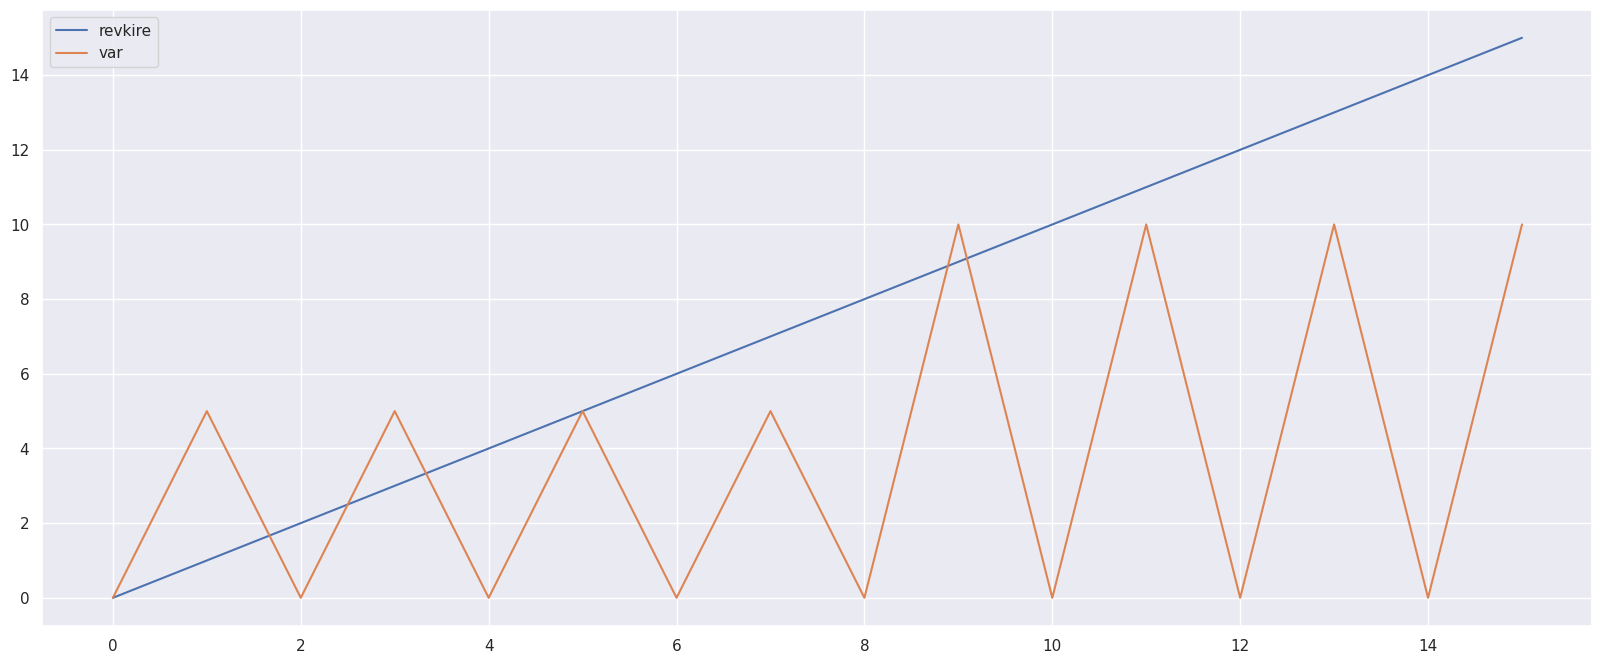

In [40]:
df.plot()

In [41]:
vaex_df = pandas_to_vaex(df)

copules = get_copules_revkire(vaex_df, 1, "var", 2, minimal_bucket_size=1)
assert len(copules["copules"]) == 1
assert len(copules["copules"][0]["buckets"]) == 3
tc.assertEqual(
    copules,
    {
        "controle": [],
        "copules": [
            {
                "lower_bound": 0,
                "upper_bound": 1000000000000000,
                "count": 16,
                "count_zero": 8,
                "count_nonzero": 8,
                "buckets": [
                    {
                        "lower_bound": 0,
                        "upper_bound": 2.5,
                        "bucket_count": 8,
                        "bucket_sum": 0,
                        "bucket_mean": 0,
                        "bucket_stdev": 0,
                        "count_above_upper_bound": 8,
                        "sum_above_upper_bound": 60.0,
                        "ratio_count_above_upper_bound": 0.5,
                        "mean_above_upper_bound": 7.5,
                    },
                    {
                        "lower_bound": 2.5,
                        "upper_bound": 7.5,
                        "bucket_count": 4,
                        "bucket_sum": 20.0,
                        "bucket_mean": 5.0,
                        "bucket_stdev": 0.0,
                        "count_above_upper_bound": 4,
                        "sum_above_upper_bound": 40.0,
                        "ratio_count_above_upper_bound": 0.25,
                        "mean_above_upper_bound": 10.0,
                    },
                    {
                        "lower_bound": 7.5,
                        "upper_bound": 10.0,
                        "bucket_count": 4,
                        "bucket_sum": 40.0,
                        "bucket_mean": 10.0,
                        "bucket_stdev": 0.0,
                        "count_above_upper_bound": 0,
                        "sum_above_upper_bound": 0,
                        "ratio_count_above_upper_bound": 0,
                        "mean_above_upper_bound": 0,
                    },
                ],
            }
        ],
    },
)

Temps d'extraction par to_arrays  0.00011205673217773438
-----------------Temps après slice 1.1920928955078125e-06
Temps avant sort 1.4543533325195312e-05
Temps après sort 1.9550323486328125e-05
get_copulas 0 : index entre idx_inf=0 et idx_sup=16 - RFR entre lower_bound=0 et upper_bound=1000000000000000 - 8 valeurs différentes de zéro.
	min(variable_values)=5.0 max(variable_values)=10.0
DistribDeVarVaex - RFR entre 0 et 1000000000000000
get_borders frontieres de base [4]
get_borders frontieres avant [4, 8]
get_borders len(borders) avant 2
get_borders frontieres apres [4, 8]
get_borders frontieres avant fin [4, 8]
borders: [4, 8]
Temps de DistribDeVarVaex 0.0002002716064453125
Temps après fin de la boucle 0.00024127960205078125 --------------


#### Test avec peu de données secondaires

In [42]:
rfr = []
nb_foy = 160
for i in range(nb_foy):
    if i > 60 and not i % 2 and not i % 4:
        var = i / 2
    else:
        var = 0.0
    un_rfr = {
        "revkire": i,
        "var": var,
    }
    rfr.append(un_rfr)
df = pd.DataFrame(rfr)
# df.describe()

<Axes: >

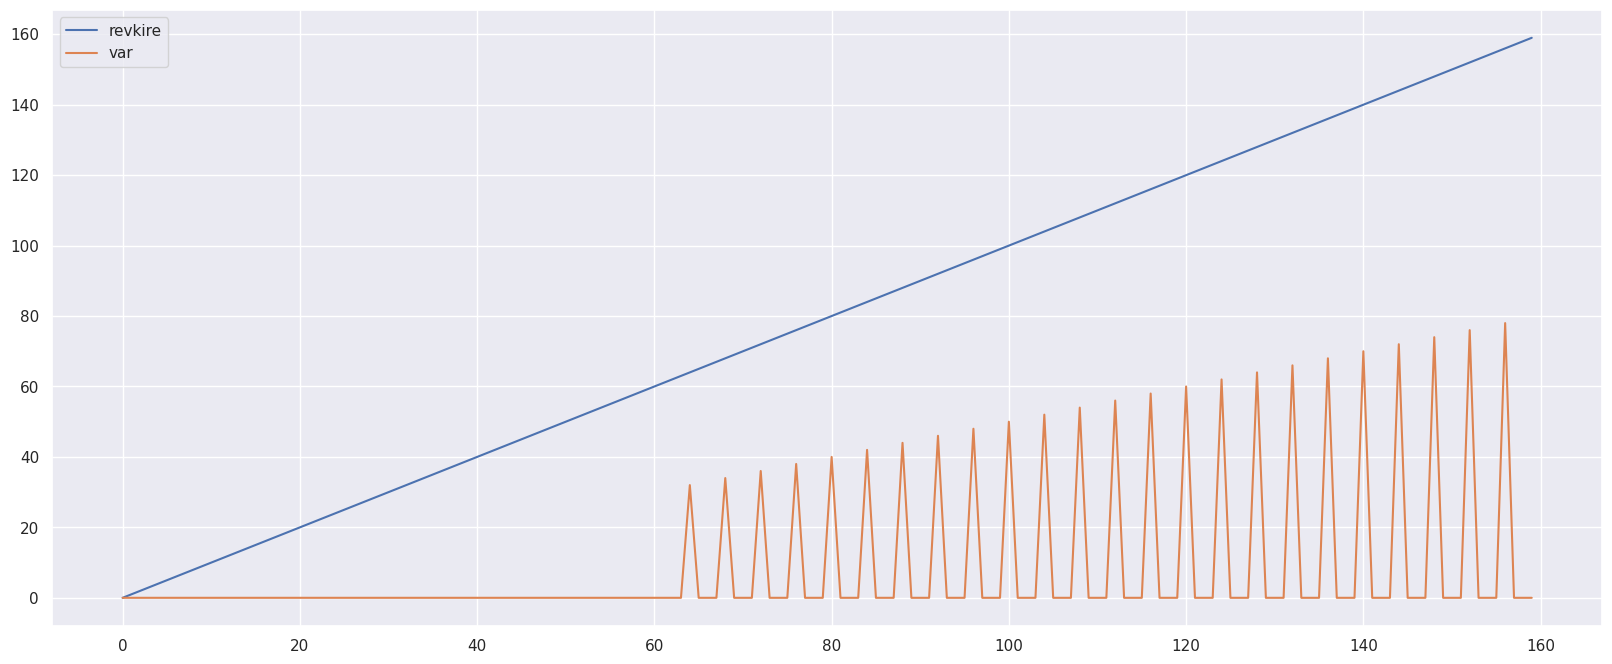

In [43]:
df.plot()

In [44]:
vaex_df = pandas_to_vaex(df)

copules = get_copules_revkire(vaex_df, 10, "var", 10, minimal_bucket_size=4)

tc.assertEqual(len(copules["copules"]), 10)
tc.assertEqual(len(copules["copules"][-1]["buckets"]), 2)
tc.assertEqual(copules["copules"][2]["buckets"], "NO_DETAIL_TO_PRESERVE_SECRET")

get_borders frontieres de base [16, 32, 48, 64, 80, 96, 112, 128, 144]
get_borders frontieres avant [16, 32, 48, 64, 80, 96, 112, 128, 144, 159, 160]
get_borders len(borders) avant 11
get_borders On supprime la frontière i 9 pour combiner les 2 buckets mitoyens : borders[i]=159, borders[i+1]=160 
get_borders frontieres apres [16, 32, 48, 64, 80, 96, 112, 128, 144, 160]
get_borders frontieres avant fin [16, 32, 48, 64, 80, 96, 112, 128, 144, 160]
Temps d'extraction par to_arrays  0.000156402587890625
-----------------Temps après slice 9.5367431640625e-07
Temps avant sort 1.3589859008789062e-05
Temps après sort 1.7881393432617188e-05
get_copulas 0 : index entre idx_inf=0 et idx_sup=16 - RFR entre lower_bound=0 et upper_bound=16 - 0 valeurs différentes de zéro.
DistribDeVarVaex - RFR entre 0 et 16
DistribDeVar : less than 4 for non_zero elements. 16 elements at 0
Temps de DistribDeVarVaex 1.5735626220703125e-05
Temps après fin de la boucle 4.696846008300781e-05 --------------
------------

#### Test vérification du tri

In [45]:
variable_values = [random.randint(1, 1000) for i in range(50)]

with tc.assertRaises(DatasetNotSorted):
    dis = DistribDeVarVaex(
        variable_values=variable_values,
        variable="variable",
        nb_entity=len(variable_values),
        nb_bucket_var=2,
        lower_bound=50,
        upper_bound=1e10,
        debug=False,
    )

#### Test deux buckets, sans 0

In [46]:
variable_values = [1 for i in range(12)] + [1 for i in range(12)]
dis = DistribDeVarVaex(
    variable_values=variable_values,
    variable="variable",
    nb_entity=len(variable_values),
    nb_bucket_var=2,
    lower_bound=50,
    upper_bound=1e10,
    debug=False,
)
res = dis.to_dict()
res
assert res["lower_bound"] == 50
assert res["count_zero"] == 0
assert res["count_nonzero"] == len(variable_values)
# Les buckets vident sont supprimés
tc.assertNotEqual(res["buckets"][0]["bucket_count"], 0)
tc.assertEqual(res["buckets"][0]["bucket_count"], len(variable_values) / 2)
assert res["buckets"][1]["bucket_count"] == len(variable_values) / 2
assert res["buckets"][0]["bucket_sum"] == sum(variable_values) / 2
assert res["buckets"][1]["bucket_sum"] == sum(variable_values) / 2
tc.assertEqual(res["buckets"][0]["bucket_stdev"], 0.0)

#### Test deux buckets, deux groupes identique, sans 0

In [47]:
variable_values = [1 for i in range(12)] + [2 for i in range(12)]
dis = DistribDeVarVaex(
    variable_values=variable_values,
    variable="variable",
    nb_entity=len(variable_values),
    nb_bucket_var=2,
    lower_bound=50,
    upper_bound=1e10,
    debug=False,
)
res = dis.to_dict()
# res
assert res["lower_bound"] == 50
assert res["count_zero"] == 0
assert res["count_nonzero"] == len(variable_values)
assert res["buckets"][0]["bucket_count"] == len(variable_values) / 2
assert res["buckets"][1]["bucket_count"] == len(variable_values) / 2
assert res["buckets"][0]["bucket_sum"] == 12
assert res["buckets"][1]["bucket_sum"] == 24

#### Test deux buckets, valeurs différentes, sans 0

In [48]:
variable_values = [1 for i in range(12)] + [i + 13 for i in range(12)]
dis = DistribDeVarVaex(
    variable_values=variable_values,
    variable="variable",
    nb_entity=len(variable_values),
    nb_bucket_var=2,
    lower_bound=50,
    upper_bound=1e10,
    debug=False,
)
res = dis.to_dict()
# res
assert res["lower_bound"] == 50
assert res["count_zero"] == 0
assert res["count_nonzero"] == len(variable_values)
# assert res["buckets"][0]["bucket_count"] == 0
assert res["buckets"][0]["bucket_count"] == len(variable_values) / 2
assert res["buckets"][1]["bucket_count"] == len(variable_values) / 2
assert res["buckets"][0]["bucket_sum"] == 12
assert res["buckets"][1]["bucket_sum"] == sum(i + 13 for i in range(12))

#### Test trois buckets, sans 0

In [49]:
variable_values = (
    [1 for i in range(12)]
    + [i + 13 for i in range(12)]
    + [i * 10 for i in range(12, 12 + 12)]
)
# variable_values.sort()
dis = DistribDeVarVaex(
    variable_values=variable_values,
    variable="variable",
    nb_entity=len(variable_values),
    nb_bucket_var=3,
    lower_bound=50,
    upper_bound=1e10,
    debug=False,
)
res = dis.to_dict()
# res
assert res["lower_bound"] == 50
assert res["count_zero"] == 0
assert res["count_nonzero"] == len(variable_values)
assert res["buckets"][0]["bucket_count"] == 12
assert res["buckets"][1]["bucket_count"] == 12
assert res["buckets"][2]["bucket_count"] == 12
assert res["buckets"][0]["bucket_sum"] == sum(1 for i in range(12))
assert res["buckets"][1]["bucket_sum"] == sum(i + 13 for i in range(12))
assert res["buckets"][2]["bucket_sum"] == sum(i * 10 for i in range(12, 12 + 12))
assert res["buckets"][0]["sum_above_upper_bound"] == sum(
    [i + 13 for i in range(12)] + [i * 10 for i in range(12, 12 + 12)]
)
assert res["buckets"][1]["sum_above_upper_bound"] == sum(
    i * 10 for i in range(12, 12 + 12)
)
assert res["buckets"][2]["sum_above_upper_bound"] == 0

#### Test trois buckets, plus un de  0

In [50]:
variable_values = (
    [1 for i in range(12)]
    + [i + 13 for i in range(12)]
    + [30 + i * 10 for i in range(12)]
)
nb_zeros = 12
variable_values
dis = DistribDeVarVaex(
    variable_values=variable_values,
    variable="variable",
    nb_entity=len(variable_values) + nb_zeros,
    nb_bucket_var=3,
    lower_bound=50,
    upper_bound=1e10,
    debug=True,
)
res = dis.to_dict()
assert res["lower_bound"] == 50
assert res["count_zero"] == nb_zeros
assert res["count_nonzero"] == len(variable_values)
assert res["buckets"][0]["bucket_count"] == 12
assert res["buckets"][1]["bucket_count"] == 12
assert res["buckets"][2]["bucket_count"] == 12
assert res["buckets"][3]["bucket_count"] == 12
assert res["buckets"][1]["bucket_sum"] == sum(1 for i in range(12))
assert res["buckets"][2]["bucket_sum"] == sum(i + 13 for i in range(12))
assert res["buckets"][3]["bucket_sum"] == sum(30 + i * 10 for i in range(12))
assert res["buckets"][1]["sum_above_upper_bound"] == sum(
    [i + 13 for i in range(12)] + [30 + i * 10 for i in range(12)]
)
assert res["buckets"][2]["sum_above_upper_bound"] == sum(30 + i * 10 for i in range(12))
assert res["buckets"][3]["sum_above_upper_bound"] == 0

DistribDeVarVaex - RFR entre 50 et 10000000000.0
get_borders frontieres de base [12, 24]
get_borders frontieres avant [12, 24, 33, 36]
get_borders len(borders) avant 4
get_borders On supprime la frontière i+1 2 pour combiner les 2 buckets mitoyens : borders[i]=24, borders[i+1]=33 , borders[i+2]=36
get_borders frontieres apres [12, 24, 36]
get_borders frontieres avant fin [12, 24, 36]
borders: [12, 24, 36]


#### Test un seul bucket, sans 0

In [51]:
variable_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
dis = DistribDeVarVaex(
    variable_values=variable_values,
    variable="variable",
    nb_entity=len(variable_values),
    nb_bucket_var=1,
    lower_bound=50,
    upper_bound=1e10,
    debug=False,
)
res = dis.to_dict()
assert res["lower_bound"] == 50
assert res["count_zero"] == 0
assert res["count_nonzero"] == 12
assert res["buckets"][0]["bucket_count"] == 12
assert res["buckets"][0]["bucket_sum"] == sum(variable_values)

#### Test bucket trop petit

In [52]:
with tc.assertRaises(SecretViolation):
    dis = DistribDeVarVaex(
        variable_values=[1, 2, 3, 4],
        variable="variable",
        nb_entity=4,
        nb_bucket_var=1,
        lower_bound=0,
        upper_bound=10 ^ 15,
        debug=False,
    )

#### Tres peu de données

In [53]:
variable_values = [i + 1 for i in range(13)]
variable = "revkire"
nb_entity = 100
bdr = DistribDeVarVaex(
    variable_values=variable_values,
    variable=variable,
    nb_entity=nb_entity,
    nb_bucket_var=4,
    debug=False,
)
result = bdr.to_dict()
# result
assert result["count_zero"] == nb_entity - len(variable_values)
assert result["count_nonzero"] == len(variable_values)
assert result["buckets"][1]["bucket_count"] == len(variable_values)
assert result["buckets"][1]["bucket_sum"] == sum(variable_values)
assert len(result["buckets"]) == 2

#### Nominal

In [54]:
expected_1_bucket = [i + 1 for i in range(20)]
expected_2_bucket = [(i + 20) * 2 for i in range(20)]
expected_3_bucket = [(i + 20 * 2) * 3 for i in range(20)]
expected_4_bucket = [(i + 20 * 3) * 4 for i in range(20)]

variable_values = (
    expected_1_bucket + expected_2_bucket + expected_3_bucket + expected_4_bucket
)
variable = "revkire"
nb_entity = 100
nb_bucket_var = 4
prev_seuil = 5648
seuil = 897456
bdr = DistribDeVarVaex(
    variable_values=variable_values,
    variable=variable,
    nb_entity=nb_entity,
    nb_bucket_var=nb_bucket_var,
    lower_bound=prev_seuil,
    upper_bound=seuil,
    debug=False,
)
result = bdr.to_dict()
# result
assert result["lower_bound"] == prev_seuil
assert result["upper_bound"] == seuil
assert result["count_zero"] == nb_entity - len(variable_values)
assert result["count_nonzero"] == len(variable_values)
assert result["buckets"][1]["bucket_count"] == len(expected_1_bucket)
assert result["buckets"][2]["bucket_count"] == len(expected_2_bucket)
assert result["buckets"][3]["bucket_count"] == len(expected_3_bucket)
assert result["buckets"][4]["bucket_count"] == len(expected_4_bucket)
assert result["buckets"][1]["bucket_sum"] == sum(expected_1_bucket)
assert result["buckets"][2]["bucket_sum"] == sum(expected_2_bucket)
assert result["buckets"][3]["bucket_sum"] == sum(expected_3_bucket)
assert result["buckets"][4]["bucket_sum"] == sum(expected_4_bucket)

#### Cas d'exactement 12 foyers

In [55]:
expected_1_bucket = [i + 1 for i in range(20)]
expected_2_bucket = [(i + 20) * 2 for i in range(20)]
expected_3_bucket = [(i + 20 * 2) * 3 for i in range(20)]
expected_4_bucket = [(i + 20 * 3) * 4 for i in range(20)]
variable_values = (
    expected_1_bucket + expected_2_bucket + expected_3_bucket + expected_4_bucket
)
variable = "revkire"
nb_entity = 100
nb_bucket_var = 4
prev_seuil = 5648
seuil = 897456
bdr = DistribDeVarVaex(
    variable_values=variable_values,
    variable=variable,
    nb_entity=nb_entity,
    nb_bucket_var=nb_bucket_var,
    lower_bound=prev_seuil,
    upper_bound=seuil,
    debug=False,
)
result = bdr.to_dict()
# result
assert result["lower_bound"] == prev_seuil
assert result["upper_bound"] == seuil
assert result["count_zero"] == nb_entity - len(variable_values)
assert result["count_nonzero"] == len(variable_values)
assert len(result["buckets"]) == 4 + 1
assert result["buckets"][0]["bucket_count"] == 20
assert result["buckets"][1]["bucket_count"] == len(expected_2_bucket)
assert result["buckets"][2]["bucket_count"] == len(expected_3_bucket)
assert result["buckets"][3]["bucket_count"] == len(expected_4_bucket)
assert result["buckets"][4]["bucket_count"] == len(expected_4_bucket)

assert result["buckets"][1]["bucket_sum"] == sum(expected_1_bucket)
assert result["buckets"][2]["bucket_sum"] == sum(expected_2_bucket)
assert result["buckets"][3]["bucket_sum"] == sum(expected_3_bucket)
assert result["buckets"][4]["bucket_sum"] == sum(expected_4_bucket)

#### Cas où il manque des foyers

In [56]:
expected_1_bucket = [i + 1 for i in range(12)]
expected_2_bucket = [(i + 20) * 2 for i in range(12)]
expected_3_bucket = [(i + 20 * 2) * 3 for i in range(12)]
expected_4_bucket = [(i + 20 * 3) * 4 for i in range(10)]

variable_values = (
    expected_1_bucket + expected_2_bucket + expected_3_bucket + expected_4_bucket
)
variable = "revkire"
nb_entity = 100
nb_bucket_var = 4
prev_seuil = 5648
seuil = 897456
# print(f"{variable_values=} {len(variable_values)=}")
bdr = DistribDeVarVaex(
    variable_values=variable_values,
    variable=variable,
    nb_entity=nb_entity,
    nb_bucket_var=nb_bucket_var,
    lower_bound=prev_seuil,
    upper_bound=seuil,
    debug=False,
)
result = bdr.to_dict()
# result
assert result["lower_bound"] == prev_seuil
assert result["upper_bound"] == seuil
assert result["count_zero"] == nb_entity - len(variable_values)
assert result["count_nonzero"] == len(variable_values)
assert len(result["buckets"]) == 3 + 1
assert result["buckets"][1]["bucket_count"] == 15
assert result["buckets"][2]["bucket_count"] == 15
assert result["buckets"][3]["bucket_count"] == 16
assert result["buckets"][0]["bucket_sum"] == 0
assert result["buckets"][1]["bucket_sum"] == 204
assert result["buckets"][2]["bucket_sum"] == 1251
assert result["buckets"][3]["bucket_sum"] == 3453
# La somme des copules de la variable doit être égale à la somme de la variable
s = 0
for i in range(len(result["buckets"])):
    s += result["buckets"][i]["bucket_sum"]
assert s == sum(variable_values)

#### Test copules

In [57]:
df = pd.DataFrame(
    {
        "revkire": [i * i for i in range(nb_entity)],
        "impot": [np.nan for i in range(nb_entity - len(variable_values))]
        + variable_values,
    }
)
fake_data = pandas_to_vaex(df)

In [58]:
une_tranche = get_primary_buckets(fake_data, 1, "revkire")
calib = get_copulas(fake_data, "revkire", "impot", 10, une_tranche)

In [59]:
tc.assertEqual(len(calib["copules"]), 1)
tc.assertEqual(len(calib["copules"][0]["buckets"]), 4)
tc.assertEqual(calib["copules"][0]["buckets"][0]["bucket_count"], 54)
tc.assertEqual(calib["copules"][0]["buckets"][-1]["bucket_count"], 16)
tc.assertEqual(calib["copules"][0]["buckets"][0]["bucket_sum"], 0)
tc.assertEqual(calib["copules"][0]["buckets"][-1]["bucket_sum"], 3453)

In [60]:
trois_tranche = get_primary_buckets(fake_data, 3, "revkire")
copules = get_copulas(fake_data, "revkire", "impot", 4, trois_tranche, debug=True)

Temps d'extraction par to_arrays  7.557868957519531e-05
-----------------Temps après slice 1.6689300537109375e-06
Temps avant sort 9.059906005859375e-06
Temps après sort 1.33514404296875e-05
get_copulas 0 : index entre idx_inf=0 et idx_sup=33 - RFR entre lower_bound=0 et upper_bound=1089 - 0 valeurs différentes de zéro.
DistribDeVarVaex - RFR entre 0 et 1089
DistribDeVar : less than 12 for non_zero elements. 33 elements at 0
Temps de DistribDeVarVaex 1.2636184692382812e-05
Temps après fin de la boucle 3.886222839355469e-05 --------------
-----------------Temps après slice 7.152557373046875e-07
Temps avant sort 5.4836273193359375e-06
Temps après sort 8.821487426757812e-06
get_copulas 1 : index entre idx_inf=33 et idx_sup=66 - RFR entre lower_bound=1089 et upper_bound=4356 - 12 valeurs différentes de zéro.
	min(variable_values)=1.0 max(variable_values)=12.0
DistribDeVarVaex - RFR entre 1089 et 4356
borders: [12]
Temps de DistribDeVarVaex 0.00010967254638671875
Temps après fin de la boucl

In [61]:
cop = copules["copules"]
tc.assertEqual(len(cop), 3)
tc.assertEqual(len(cop[-1]["buckets"]), 2)
tc.assertEqual(cop[0]["buckets"], SECRET_KEEPED)
tc.assertEqual(cop[1]["buckets"][0]["bucket_count"], 21)
tc.assertEqual(cop[1]["buckets"][-1]["bucket_count"], 12)
tc.assertEqual(cop[1]["buckets"][0]["bucket_sum"], 0)
tc.assertEqual(cop[1]["buckets"][-1]["bucket_sum"], 78)

tc.assertEqual(cop[-1]["buckets"][0]["bucket_count"], 17)
tc.assertEqual(cop[-1]["buckets"][-1]["bucket_count"], 17)
tc.assertEqual(cop[-1]["buckets"][0]["bucket_sum"], 1242)
tc.assertEqual(cop[-1]["buckets"][-1]["bucket_sum"], 3588)

#### Cas où un foyer dépasse les autres, à la fin

In [62]:
above = 4500
expected_1_bucket = [i + 1 for i in range(20)]
expected_2_bucket = [(i + 20) * 2 for i in range(20)]
expected_3_bucket = [(i + 20 * 2) * 3 for i in range(20)]
expected_4_bucket = [(i + 20 * 3) * 4 for i in range(19)] + [above]  # 0.851

variable_values = (
    expected_1_bucket + expected_2_bucket + expected_3_bucket + expected_4_bucket
)

print((sum(expected_4_bucket) - above) * 0.85)
print(above / (sum(expected_4_bucket) - above))

variable = "revkire"
nb_entity = 100
nb_bucket_var = 4
prev_seuil = 5648
seuil = 897456

# print(f"{variable_values=} {len(variable_values)=}")

bdr = DistribDeVarVaex(
    variable_values=variable_values,
    variable=variable,
    nb_entity=nb_entity,
    nb_bucket_var=nb_bucket_var,
    lower_bound=prev_seuil,
    upper_bound=seuil,
    debug=True,
)
result = bdr.to_dict()
# result
assert result["lower_bound"] == prev_seuil
assert result["upper_bound"] == seuil
assert result["count_zero"] == nb_entity - len(variable_values)
assert result["count_nonzero"] == len(variable_values)
assert len(result["buckets"]) == 4  # Et non 5 à cause du secret statistique
# assert result["buckets"] == ["SECRET STATISTIQUE NON RESPECTE"]
# La somme des copules de la variable doit être égale à la somme de la variable
s = 0
for i in range(len(result["buckets"])):
    s += result["buckets"][i]["bucket_sum"]
assert s == sum(variable_values)

4457.4
0.8581235697940504
DistribDeVarVaex - RFR entre 5648 et 897456
get_borders frontieres de base [20, 40, 60]
get_borders frontieres avant [20, 40, 60, 72, 80]
get_borders len(borders) avant 5
get_borders On supprime la frontière i 3 pour combiner les 2 buckets mitoyens : borders[i]=72, borders[i+1]=80 
get_borders frontieres apres [20, 40, 60, 80]
get_borders frontieres avant fin [20, 40, 60, 80]
borders: [20, 40, 60, 80]
DistribDeVarVaex : Warning SECRET STATISTIQUE > 0.85 NON RESPECTE (idrk=79), on refait une passe avec moins de frontières
sum_var_bucket=9744, max_ff_bucket=4500,currbuck=3, nb_bucket_var=4, add_upper_bucket=[0.1]
get_borders frontieres de base [20, 40, 60]
get_borders frontieres avant [20, 40, 60, 72, 80]
get_borders len(borders) avant 5
get_borders On supprime la frontière i 3 pour combiner les 2 buckets mitoyens : borders[i]=72, borders[i+1]=80 
get_borders frontieres apres [20, 40, 60, 80]
get_borders frontieres avant fin [20, 40, 60, 80]
borders: [20, 40, 60

#### Cas où un foyer dépasse beaucoup trop les autres

In [63]:
expected_1_bucket = [i + 1 for i in range(20)]
expected_2_bucket = [(i + 20) * 2 for i in range(20)]
expected_3_bucket = [(i + 20 * 2) * 3 for i in range(20)]
expected_4_bucket = (
    [(i + 20 * 3) * 4 for i in range(9)]
    + [30000]
    + [(i + 20 * 3) * 4 for i in range(10)]
)  # 0.851

variable_values = (
    expected_1_bucket + expected_2_bucket + expected_3_bucket + expected_4_bucket
)
variable = "revkire"
nb_entity = 100
nb_bucket_var = 4
prev_seuil = 5648
seuil = 897456

# print(f"{variable_values=} {len(variable_values)=}")
with tc.assertRaises(SecretViolation):
    bdr = DistribDeVarVaex(
        variable_values=variable_values,
        variable=variable,
        nb_entity=nb_entity,
        nb_bucket_var=nb_bucket_var,
        lower_bound=prev_seuil,
        upper_bound=seuil,
        debug=False,
    )

#### Cas où un foyer dépasse les autres, au milieu

In [64]:
expected_1_bucket = [i + 1 for i in range(20)]
expected_2_bucket = [(i + 20) * 2 for i in range(20)]
expected_3_bucket = [(i + 20 * 2) * 3 for i in range(20)]
expected_4_bucket = (
    [(i + 20 * 3) * 4 for i in range(9)]
    + [4500]
    + [(i + 20 * 3) * 4 for i in range(10)]
)  # 0.851

variable_values = (
    expected_1_bucket + expected_2_bucket + expected_3_bucket + expected_4_bucket
)
variable = "revkire"
nb_entity = 100
nb_bucket_var = 4
prev_seuil = 5648
seuil = 897456

# print(f"{variable_values=} {len(variable_values)=}")

bdr = DistribDeVarVaex(
    variable_values=variable_values,
    variable=variable,
    nb_entity=nb_entity,
    nb_bucket_var=nb_bucket_var,
    lower_bound=prev_seuil,
    upper_bound=seuil,
    debug=False,
)
result = bdr.to_dict()
# result
assert result["lower_bound"] == prev_seuil
assert result["upper_bound"] == seuil
assert result["count_zero"] == nb_entity - len(variable_values)
assert result["count_nonzero"] == len(variable_values)
# assert result["buckets"] == ["SECRET STATISTIQUE NON RESPECTE"]
# La somme des copules de la variable doit être égale à la somme de la variable
s = 0
for i in range(len(result["buckets"])):
    s += result["buckets"][i]["bucket_sum"]
assert s == sum(variable_values)

#### Vérification du calcul de la variance

In [65]:
expected_2_bucket = [2, 2, 2, 2, 2, 2]
expected_3_bucket = [4, 4, 4, 6, 6, 6]
expected_4_bucket = [200, 97, 97, 150, 400.654, 6.4658]
variable_values = expected_2_bucket + expected_3_bucket + expected_4_bucket
variable_values.sort()
dis = DistribDeVarVaex(
    variable_values=variable_values,
    variable="variable",
    nb_entity=len(variable_values),
    nb_bucket_var=3,
    minimal_bucket_size=1,
    debug=True,
)
res = dis.to_dict()
tc.assertEqual(res["buckets"][0]["bucket_stdev"], statistics.stdev(expected_2_bucket))
tc.assertEqual(res["buckets"][1]["bucket_stdev"], statistics.stdev(expected_3_bucket))
tc.assertEqual(res["buckets"][2]["bucket_stdev"], statistics.stdev(expected_4_bucket))

DistribDeVarVaex - RFR entre 0 et 5
get_borders frontieres de base [6, 12]
get_borders frontieres avant [6, 12, 17, 18]
get_borders len(borders) avant 4
get_borders frontieres apres [6, 12, 17, 18]
get_borders frontieres avant fin [6, 12, 17, 18]
borders: [6, 12, 17, 18]


#### Exemple de décile d'une variable par rapport à une autre

In [66]:
df = get_fake_data(set_some_var_to_zero=True, set_some_var_to_negative=False)
rfrs_sorted = pandas_to_vaex(df)

In [67]:
tranche_rfr_10 = get_primary_buckets(rfrs_sorted, 10, add_upper_bucket=[])

In [68]:
out = get_copulas(
    rfrs_sorted,
    "revkire",
    "var",
    nb_bucket_var=1,
    primary_buckets=tranche_rfr_10,
    add_upper_bucket=[],
    debug=False,
)
tc.assertEqual(len(out["copules"]), 10)
somme = 0
for c in out["copules"]:
    somme += c["buckets"][-1]["bucket_sum"]
tc.assertEqual(rfrs_sorted["var"].sum(), somme)

## Tests de la préparation des tranches de variables à analyser
### Tests avec peu de données

In [69]:
# vdf_test

In [70]:
%%time
out = get_copulas(
    vdf_test,
    "revkire",
    variable_small_test,
    nb_bucket_var_small_test,
    tranche_rfr_small_test,
    debug=True,
)

Temps d'extraction par to_arrays  0.00015282630920410156
-----------------Temps après slice 9.5367431640625e-07
Temps avant sort 1.4066696166992188e-05
Temps après sort 2.0265579223632812e-05
get_copulas 0 : index entre idx_inf=0 et idx_sup=18 - RFR entre lower_bound=0 et upper_bound=35 - 15 valeurs différentes de zéro.
	min(variable_values)=4 max(variable_values)=95
DistribDeVarVaex - RFR entre 0 et 35
DistribDeVar : less than 12 for zero elements. 3 elements at 0
borders: [15]
Temps de DistribDeVarVaex 0.00013828277587890625
Temps après fin de la boucle 0.00018143653869628906 --------------
-----------------Temps après slice 4.76837158203125e-07
Temps avant sort 7.867813110351562e-06
Temps après sort 1.2874603271484375e-05
get_copulas 1 : index entre idx_inf=18 et idx_sup=36 - RFR entre lower_bound=35 et upper_bound=61 - 18 valeurs différentes de zéro.
	min(variable_values)=10 max(variable_values)=89
DistribDeVarVaex - RFR entre 35 et 61
borders: [18]
Temps de DistribDeVarVaex 8.5592

In [71]:
len(out["copules"][-1]["buckets"])

1

In [72]:
tc.assertEqual(len(out["copules"]), len(tranche_rfr_small_test["borders"]))
tc.assertIn(len(out["copules"][-1]["buckets"]), [1, 2])

In [73]:
# out

In [74]:
# La somme des copules de la variable doit être égale à la somme de la variable
s = 0
for i in range(len(out["copules"])):
    for j in range(len(out["copules"][i]["buckets"])):
        s += out["copules"][i]["buckets"][j]["bucket_sum"]
assert s == int(vdf_test.sum(f"{variable_small_test}"))

In [75]:
out["copules"][0]

{'lower_bound': 0,
 'upper_bound': 35,
 'count': 'NO_DETAIL_TO_PRESERVE_SECRET',
 'count_zero': 'NO_DETAIL_TO_PRESERVE_SECRET',
 'count_nonzero': 'NO_DETAIL_TO_PRESERVE_SECRET',
 'buckets': [{'lower_bound': 0,
   'upper_bound': 2.0,
   'bucket_count': 'NO_DETAIL_TO_PRESERVE_SECRET',
   'bucket_sum': 0,
   'bucket_mean': 0,
   'bucket_stdev': 0,
   'count_above_upper_bound': 15,
   'sum_above_upper_bound': 815,
   'ratio_count_above_upper_bound': 0.8333333333333334,
   'mean_above_upper_bound': 54.333333333333336},
  {'lower_bound': 2.0,
   'upper_bound': 92,
   'bucket_count': 15,
   'bucket_sum': 815,
   'bucket_mean': 54.333333333333336,
   'bucket_stdev': 33.542439358151015,
   'count_above_upper_bound': 0,
   'sum_above_upper_bound': 0,
   'ratio_count_above_upper_bound': 0,
   'mean_above_upper_bound': 0}]}

In [76]:
# La somme des foyers des copules doit être égale au nombre de ligne dans le jeux de test
s = 0
# for i in range(3):
#     s += out["copules"][i]["count"] if type(out["copules"][i]["count"]) is int else 0
for i in range(len(out["copules"])):
    for j in range(len(out["copules"][i]["buckets"])):
        c = out["copules"][i]["buckets"][j]["bucket_count"]
        s += c if isinstance(c, int) else 0
tc.assertEqual(
    s + 3, int(vdf_test.count(variable_small_test))
)  # +3 because 3 elements at 0 only

AssertionError: 56 != 55

In [95]:
out["copules"][0]

{'lower_bound': 0,
 'upper_bound': 22,
 'count': 'NO_DETAIL_TO_PRESERVE_SECRET',
 'count_zero': 'NO_DETAIL_TO_PRESERVE_SECRET',
 'count_nonzero': 'NO_DETAIL_TO_PRESERVE_SECRET',
 'buckets': [{'lower_bound': 0,
   'upper_bound': 0.5,
   'bucket_count': 'NO_DETAIL_TO_PRESERVE_SECRET',
   'bucket_sum': 0,
   'bucket_mean': 0,
   'bucket_stdev': 0,
   'count_above_upper_bound': 14,
   'sum_above_upper_bound': 887,
   'ratio_count_above_upper_bound': 0.7777777777777778,
   'mean_above_upper_bound': 63.357142857142854},
  {'lower_bound': 0.5,
   'upper_bound': 99,
   'bucket_count': 14,
   'bucket_sum': 887,
   'bucket_mean': 63.357142857142854,
   'bucket_stdev': 30.256867352355265,
   'count_above_upper_bound': 0,
   'sum_above_upper_bound': 0,
   'ratio_count_above_upper_bound': 0,
   'mean_above_upper_bound': 0}]}

In [96]:
# La somme des foyers des copules doit être égale au nombre de ligne supérieure à 0 dans le jeux de test
s = 0
for i in range(3):
    s += out["copules"][i]["buckets"][-1]["bucket_count"]
tc.assertEqual(
    s,
    int(
        vdf_test.count(
            variable_small_test, selection=[vdf_test[variable_small_test] > 0]
        )
    ),
)

### Test avec beaucoup de petites valeurs

In [97]:
variable_small_test = "ma_var"
nb_bucket_rfr_small_test2 = 10
nb_bucket_var_small_test2 = 3
test_dict = {
    "revkire": [0 for i in range(50)] + [i + 1 for i in range(110)] + [500_000],
    variable_small_test: [0 for i in range(50)] + [i + 1 for i in range(110)] + [100],
}
vdf_test2 = vaex.from_dict(test_dict)
tranche_rfr_small_test2 = get_primary_buckets(
    vdf_test2, nb_bucket_rfr_small_test2, debug=True
)
tranche_rfr_small_test2

get_borders frontieres de base [16, 32, 48, 64, 80, 96, 112, 128, 144]
get_borders frontieres avant [16, 32, 48, 64, 80, 96, 112, 128, 144, 145, 160, 161]
get_borders len(borders) avant 12
get_borders On supprime la frontière i+1 9 pour combiner les 2 buckets mitoyens : borders[i]=144, borders[i+1]=145 , borders[i+2]=160
get_borders On supprime la frontière i 9 pour combiner les 2 buckets mitoyens : borders[i]=160, borders[i+1]=161 
get_borders frontieres apres [16, 32, 48, 64, 80, 96, 112, 128, 144, 161]
get_borders frontieres avant fin [16, 32, 48, 64, 80, 96, 112, 128, 144, 161]


{'borders_values': [0, 15, 31, 47, 63, 79, 95, 1000000000000000],
 'borders': [64, 80, 96, 112, 128, 144, 161]}

In [98]:
assert tranche_rfr_small_test2["borders"][-1] == vdf_test2.count()
assert len(tranche_rfr_small_test2["borders"]) == 7
assert tranche_rfr_small_test2["borders"] == [64, 80, 96, 112, 128, 144, 161]

In [99]:
out = get_copulas(
    vdf=vdf_test2,
    primary_variable="revkire",
    variable=variable_small_test,
    nb_bucket_var=nb_bucket_var_small_test2,
    primary_buckets=tranche_rfr_small_test2,
    debug=False,
)

In [100]:
# La somme des copules de la variable doit être égale à la somme de la variable
s = 0
for i in range(len(out["copules"])):
    s += out["copules"][i]["buckets"][-1]["bucket_sum"]
tc.assertEqual(s, int(vdf_test2.sum(f"{variable_small_test}")))

In [101]:
# La somme des foyers des copules doit être égale au nombre de ligne dans le jeux de test
s = 0
for i in range(len(out["copules"])):
    s += out["copules"][i]["count_zero"] + out["copules"][i]["count_nonzero"]
assert s == int(vdf_test2.count(variable_small_test))

In [102]:
# La somme des foyers des copules doit être égale au nombre de ligne supérieure à 0 dans le jeux de test
s = 0
for i in range(len(out["copules"])):
    s += out["copules"][i]["buckets"][-1]["bucket_count"]
assert s == int(
    vdf_test2.count(variable_small_test, selection=[vdf_test[variable_small_test] > 0])
)

## Test sanitize_bucket

In [ ]:
# TODO sanitize_bucket()

## Test enforce secret in entity number

In [103]:
d = {
    "count_zero": "whatever",
    "count_nonzero": "whatever",
}
with tc.assertRaises(SecretViolation):
    enforce_secret(d, 0, 0, 12)
enforce_secret(d, 0, 12, 12)
tc.assertEqual(d, {"count_zero": 0, "count_nonzero": 12})
enforce_secret(d, 12, 0, 12)
tc.assertEqual(d, {"count_zero": 12, "count_nonzero": 0})
enforce_secret(d, 12, 1, 12)
tc.assertEqual(d, {"count_zero": SECRET_KEEPED, "count_nonzero": SECRET_KEEPED})
enforce_secret(d, 10, 10, 12)
tc.assertEqual(d, {"count_zero": SECRET_KEEPED, "count_nonzero": SECRET_KEEPED})
enforce_secret(d, 12, 10, 12)
tc.assertEqual(d, {"count_zero": SECRET_KEEPED, "count_nonzero": SECRET_KEEPED})
enforce_secret(d, 10, 12, 12)
tc.assertEqual(d, {"count_zero": SECRET_KEEPED, "count_nonzero": SECRET_KEEPED})
enforce_secret(d, 12, 12, 12)
tc.assertEqual(d, {"count_zero": 12, "count_nonzero": 12})
enforce_secret(d, 300, 11, 12)
tc.assertEqual(d, {"count_zero": SECRET_KEEPED, "count_nonzero": SECRET_KEEPED})
enforce_secret(d, 12, 300, 12)
tc.assertEqual(d, {"count_zero": 12, "count_nonzero": 300})

## Test Secret (petit nombre à zéros)

In [104]:
variable_small_test = "ma_var"
nb_bucket_rfr_small_test2 = 10
nb_bucket_var_small_test2 = 3
test_dict = {
    "revkire": [0 for i in range(5)] + [i + 1 for i in range(110)] + [500_000],
    variable_small_test: [0 for i in range(5)] + [i + 1 for i in range(110)] + [100],
}
vdf_test2 = vaex.from_dict(test_dict)
tranche_rfr_small_test2 = get_primary_buckets(
    vdf_test2, nb_bucket_rfr_small_test2, debug=False
)
tranche_rfr_small_test2
out = get_copulas(
    vdf=vdf_test2,
    primary_variable="revkire",
    variable=variable_small_test,
    nb_bucket_var=nb_bucket_var_small_test2,
    primary_buckets=tranche_rfr_small_test2,
    debug=False,
)

DistribDeVar : less than 12 for zero elements. 5 elements at 0
DistribDeVar : less than 12 for non_zero elements. 5 elements at 0


## Test Secret (anonimyze_lower_and_upper_bound)

In [105]:
calib = [{"lower_bound": 0, "upper_bound": 58}, {"lower_bound": 0, "upper_bound": 68}]
anonimyze_lower_and_upper_bound(calib)
tc.assertEqual(
    calib,
    [{"lower_bound": 0, "upper_bound": 58}, {"lower_bound": 0, "upper_bound": 100}],
)

In [106]:
calib = [
    {"lower_bound": -10, "upper_bound": 58},
    {"lower_bound": 58, "upper_bound": 68},
]
anonimyze_lower_and_upper_bound(calib)
tc.assertEqual(
    calib,
    [{"lower_bound": -10, "upper_bound": 58}, {"lower_bound": 58, "upper_bound": 100}],
)

In [107]:
calib = [{"lower_bound": 1, "upper_bound": 58}, {"lower_bound": 58, "upper_bound": 68}]
anonimyze_lower_and_upper_bound(calib)
tc.assertEqual(
    calib,
    [{"lower_bound": 1, "upper_bound": 58}, {"lower_bound": 58, "upper_bound": 100}],
)

In [108]:
calib = [
    {"lower_bound": -10_531, "upper_bound": 58},
    {"lower_bound": 58, "upper_bound": 68},
]
anonimyze_lower_and_upper_bound(calib)
tc.assertEqual(
    calib,
    [
        {"lower_bound": -100_000, "upper_bound": 58},
        {"lower_bound": 58, "upper_bound": 100},
    ],
)

### Distribution with infos

In [109]:
calib = {
    "lower_bound": 0.0,
    "upper_bound": 12124000.0,
    "buckets": [
        {
            "lower_bound": -10580.0,
            "upper_bound": 5.0,
        }
    ],
}

anonimyze_lower_and_upper_bound(calib)
tc.assertEqual(
    calib,
    {
        "lower_bound": 0.0,
        "upper_bound": 100_000_000.0,
        "buckets": [
            {
                "lower_bound": -100_000,
                "upper_bound": 10.0,
            }
        ],
    },
)

In [110]:
# Test with return value instead of modified input
calib = {
    "lower_bound": 0.0,
    "upper_bound": 12124000.0,
    "buckets": [
        {
            "lower_bound": -10580.0,
            "upper_bound": 5.0,
        }
    ],
}

tc.assertEqual(
    anonimyze_lower_and_upper_bound(calib),
    {
        "lower_bound": 0.0,
        "upper_bound": 100_000_000.0,
        "buckets": [
            {
                "lower_bound": -100_000,
                "upper_bound": 10.0,
            }
        ],
    },
)

In [111]:
copule = [
    {"upper_bound": 58, "buckets": [{"upper_bound": 28}, {"upper_bound": 68}]},
    {"upper_bound": 68, "buckets": [{"upper_bound": 158}, {"upper_bound": 168}]},
]
anonimyze_lower_and_upper_bound(copule)
# copule
tc.assertEqual(copule[0].get("upper_bound"), 58)
tc.assertEqual(copule[0]["buckets"][0]["upper_bound"], 28)
tc.assertEqual(copule[0]["buckets"][-1]["upper_bound"], 100)
tc.assertEqual(copule[-1].get("upper_bound"), 100)
tc.assertEqual(copule[-1]["buckets"][-1]["upper_bound"], 1000)

In [112]:
copule = [
    {
        "lower_bound": -9_999.99,
        "upper_bound": 58,
        "buckets": [
            {"lower_bound": -20_589.58, "upper_bound": 28},
            {"lower_bound": 28, "upper_bound": 68},
        ],
    },
    {
        "lower_bound": 58,
        "upper_bound": 68,
        "buckets": [
            {"lower_bound": -2_500.33, "upper_bound": 158},
            {"lower_bound": 54_584_848, "upper_bound": 168},
        ],
    },
]
anonimyze_lower_and_upper_bound(copule)
# copule
# test Lower bound
tc.assertEqual(copule[0].get("lower_bound"), -9999.99)  # No change : to short
tc.assertEqual(
    copule[-1].get("lower_bound"), 58
)  # No change : no secret for this position
tc.assertEqual(copule[0]["buckets"][0]["lower_bound"], -100_000)  # Changed
tc.assertEqual(
    copule[0]["buckets"][-1]["lower_bound"], 28
)  # No change : no secret for this position
tc.assertEqual(
    copule[-1]["buckets"][0]["lower_bound"], -2500.33
)  # No change : to short
tc.assertEqual(
    copule[-1]["buckets"][-1]["lower_bound"], 54_584_848
)  # No change : no secret for this position
# tests Upper bound
tc.assertEqual(copule[0].get("upper_bound"), 58)
tc.assertEqual(copule[0]["buckets"][0]["upper_bound"], 28)
tc.assertEqual(copule[0]["buckets"][-1]["upper_bound"], 100)
tc.assertEqual(copule[-1].get("upper_bound"), 100)
tc.assertEqual(copule[-1]["buckets"][-1]["upper_bound"], 1000)

In [113]:
copule = [
    {
        "lower_bound": -9_999.99,
        "upper_bound": 58,
        "buckets": [
            {"lower_bound": 28, "upper_bound": 28},
            {"lower_bound": 28, "upper_bound": 68},
        ],
    },
    {
        "lower_bound": 58,
        "upper_bound": 68,
        "buckets": [
            {"lower_bound": -2_500.33, "upper_bound": 158},
            {"lower_bound": 54_584_848, "upper_bound": 168_000_000},
        ],
    },
]
_ = anonimyze_lower_and_upper_bound(copule, min_len=0)
# copule
# test Lower bound
tc.assertEqual(copule[0].get("lower_bound"), -10_000)  # Changed
tc.assertEqual(
    copule[-1].get("lower_bound"), 58
)  # No change : no secret for this position
tc.assertEqual(
    copule[0]["buckets"][0]["lower_bound"], 28
)  # No change : It will have became greater than upper_bound
tc.assertEqual(
    copule[0]["buckets"][-1]["lower_bound"], 28
)  # No change : no secret for this position
tc.assertEqual(copule[-1]["buckets"][0]["lower_bound"], -10_000)  # Changed
tc.assertEqual(
    copule[-1]["buckets"][-1]["lower_bound"], 54_584_848
)  # No change : no secret for this position

In [115]:
with open(
    "/mnt/data-in/casd_extract/pote/20220414_ExtractAgg/data/CopulePote-100-2019-impot.json"
) as myfile:
    copule = json.loads(myfile.read())
copule = copule["copules"]
_ = anonimyze_lower_and_upper_bound(copule)

In [116]:
tc.assertEqual(copule[0]["buckets"][-1]["upper_bound"], 1000000)

In [117]:
with open(
    "/mnt/data-in/casd_extract/pote/20220407_ExtractAgg/data/CalibPote-10-2019-impot.json"
) as myfile:
    calib = json.loads(myfile.read())
_ = anonimyze_lower_and_upper_bound(calib)

In [118]:
tc.assertEqual(calib[-1]["upper_bound"], 100000000)

## Test convertion in 2D array

### Nominal test 

In [119]:
out = get_copulas(
    vdf_test,
    "revkire",
    variable_small_test,
    nb_bucket_var_small_test,
    tranche_rfr_small_test,
    debug=False,
)

DistribDeVar : less than 12 for zero elements. 4 elements at 0


In [120]:
copulas_2d = copulas_to_array(out["copules"])
tc.assertEqual(len(copulas_2d["array"]), 3)
tc.assertEqual(len(copulas_2d["col_lower_bound"]), 3)
tc.assertEqual(len(copulas_2d["row_lower_bound"]), 2)

### Empty bucket

In [121]:
out["copules"][-1]["lower_bound"] = np.nan
out["copules"][-1]["buckets"] = SECRET_KEEPED
copulas_2d = copulas_to_array(out["copules"])

tc.assertEqual(len(copulas_2d["array"]), 3)
tc.assertEqual(len(copulas_2d["col_lower_bound"]), 3)
tc.assertEqual(len(copulas_2d["row_lower_bound"]), 2)

----